<a href="https://colab.research.google.com/github/h4ck4l1/datasets/blob/main/NLP_with_RNN_and_Attention/transformers_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os,sys,warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
warnings.filterwarnings("ignore")
if "google.colab" in sys.modules:
    !pip install "tensorflow-text==2.13.0"
    !pip install einops
    !pip install -U kaleido
from IPython.display import clear_output
from zipfile import ZipFile
from typing import Literal
import shutil
import numpy as np
import einops as ep
import re
import tensorflow as tf
from tensorflow import keras
import tensorflow_text as tftext
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_dark"
import matplotlib.pyplot as plt
%matplotlib inline
tf.get_logger().setLevel("ERROR")
gpus = tf.config.list_physical_devices("GPU")
tf.config.set_logical_device_configuration(gpus[0],[tf.config.LogicalDeviceConfiguration(memory_limit=9000)])
clear_output()

In [2]:
if "google.colab" in sys.modules:
    url = "https://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip"
    file_path = keras.utils.get_file(fname="spa-eng.zip",origin=url,extract=True)
    with ZipFile(file_path,"r") as f:
        f.extractall("spa-eng")
    with open("spa-eng/spa-eng/spa.txt","r") as f:
        text = f.read()
else:
    with open("spa-eng/spa-eng/spa.txt","r") as f:
        text = f.read()

en_text,es_text = zip(*[line.split("\t") for line in text.splitlines()])
for en,es in zip(en_text[:10],es_text[:10]):
    print(f"{en} ----> {es}")

Go. ----> Ve.
Go. ----> Vete.
Go. ----> Vaya.
Go. ----> Váyase.
Hi. ----> Hola.
Run! ----> ¡Corre!
Run. ----> Corred.
Who? ----> ¿Quién?
Fire! ----> ¡Fuego!
Fire! ----> ¡Incendio!


In [3]:
def standardize(sentence:str):
    sentence = tftext.normalize_utf8(sentence,"NFKD")
    sentence = tf.strings.lower(sentence)
    sentence = tf.strings.regex_replace(sentence,r"[^ a-z?!,.¿]","")
    sentence = tf.strings.regex_replace(sentence,r"[?!.,¿]",r" \0 ")
    sentence = tf.strings.strip(sentence)
    return sentence

In [4]:
spa_ds = (
    tf.data.Dataset
    .from_tensor_slices(np.array(es_text))
    .map(standardize)
)
en_ds = (
    tf.data.Dataset
    .from_tensor_slices(np.array(en_text))
    .map(standardize)
)

spa_vocab = bert_vocab.bert_vocab_from_dataset(
    spa_ds,
    vocab_size=5000,
    reserved_tokens=["[PAD]","[UNK]","[START]","[END]"],
    bert_tokenizer_params=dict(normalization_form="NFKD"),
    learn_params={}
)


en_vocab = bert_vocab.bert_vocab_from_dataset(
    en_ds,
    vocab_size=5000,
    reserved_tokens=["[PAD]","[UNK]","[START]","[END]"],
    bert_tokenizer_params=dict(normalization_form="NFKD"),
    learn_params={}
)

In [5]:
print(en_vocab[:10])
print(en_vocab[-10:])

['[PAD]', '[UNK]', '[START]', '[END]', '!', ',', '.', '?', 'a', 'b']
['yell', 'youngest', 'youth', '##!', '##,', '##.', '##?', '##j', '##q', '##v']


In [6]:
with open("en_vocab.txt","w") as f:
    for token in en_vocab:
        print(token,file=f)


with open("spa_vocab.txt","w") as f:
    for token in spa_vocab:
        print(token,file=f)

In [7]:
print(len(spa_vocab))
print(len(en_vocab))

4870
4563


In [8]:
spa_tokenizer = tftext.BertTokenizer("spa_vocab.txt",normalization_form="NFKD")
en_tokenizer = tftext.BertTokenizer("en_vocab.txt",normalization_form="NFKD")

In [9]:
spa_ex = spa_tokenizer.tokenize(standardize(es_text[1000:1010])).merge_dims(-2,-1)
spa_ex

<tf.RaggedTensor [[37, 42, 11, 4866, 6], [37, 46, 77, 4], [37, 42, 14, 1566, 4656, 6],
 [37, 42, 981, 6], [37, 42, 14, 4107, 3382, 6],
 [37, 42, 45, 832, 4867, 4387, 6], [37, 42, 427, 6],
 [37, 44, 25, 136, 233, 6], [48, 163, 37, 6], [48, 2184, 6]]>

In [10]:
for i,j in zip(tf.strings.reduce_join(spa_tokenizer.detokenize(spa_ex),separator=" ",axis=-1),es_text[1000:1010]):
    print(i.numpy(),"<----->",j)

b'el es dj .' <-----> Él es DJ.
b'el esta aqui !' <-----> ¡Él está aquí!
b'el es gentil .' <-----> Él es gentil.
b'el es amable .' <-----> Él es amable.
b'el es generoso .' <-----> Él es generoso.
b'el es mezquino .' <-----> Él es mezquino.
b'el es alto .' <-----> Él es alto.
b'el se reia .' <-----> Él se reía.
b'lo hizo el .' <-----> Lo hizo él.
b'lo logro .' <-----> Lo logró.


In [11]:
START = tf.argmax(tf.equal(spa_vocab,"[START]"))
END = tf.argmax(tf.equal(spa_vocab,"[END]"))
print(START.numpy(),END.numpy())

2 3


In [12]:
def up_stream_processing(sentence:str,lang:Literal["es","en"]):
    assert lang in ["es","en"], f"{lang} is not in the opitons ['es','en']"
    sentence = tftext.normalize_utf8(sentence,"NFKD")
    sentence = tf.strings.lower(sentence)
    sentence = tf.strings.regex_replace(sentence,r"[^ a-z?!,.¿]","")
    sentence = tf.strings.regex_replace(sentence,r"[?!.,¿]",r" \0 ")
    sentence = tf.strings.strip(sentence)
    if lang == "en":
        tokens = en_tokenizer.tokenize(sentence).merge_dims(-2,-1)
    else:
        tokens = spa_tokenizer.tokenize(sentence).merge_dims(-2,-1)
    batch_shape = tf.shape(tokens)[0]
    start_tokens = tf.fill(dims=[batch_shape,1],value=START)
    end_tokens = tf.fill(dims=[batch_shape,1],value=END)
    return tf.concat([start_tokens,tokens,end_tokens],axis=-1)

In [13]:
def down_stream_processing(tokens,lang:Literal["en","es"]):
    if lang == "en":
        words = en_tokenizer.detokenize(tokens)
    else:
        words = spa_tokenizer.detokenize(tokens)
    bad_tokens = "|".join([re.escape(tok) for tok in ["[PAD]","[START]","[END]"]])
    mask = tf.strings.regex_full_match(words,bad_tokens)
    full_sentence = tf.ragged.boolean_mask(words,~mask)
    return tf.strings.reduce_join(full_sentence,axis=-1,separator=" ")

In [14]:
ex_tokens = up_stream_processing(en_text[1000:1010],"en")
ex_tokens

<tf.RaggedTensor [[2, 39, 38, 8, 11, 4560, 6, 3], [2, 39, 38, 88, 4, 3],
 [2, 39, 38, 354, 6, 3], [2, 39, 38, 354, 6, 3], [2, 39, 38, 354, 6, 3],
 [2, 39, 38, 571, 6, 3], [2, 39, 38, 730, 6, 3], [2, 39, 1018, 6, 3],
 [2, 39, 173, 43, 6, 3], [2, 39, 173, 43, 6, 3]]>

In [15]:
round_trip_tokens = down_stream_processing(ex_tokens,"en")
round_trip_tokens

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'he is a dj .', b'he is here !', b'he is kind .', b'he is kind .',
       b'he is kind .', b'he is mean .', b'he is tall .', b'he laughed .',
       b'he made it .', b'he made it .'], dtype=object)>

In [16]:
ex_tokens.row_lengths()

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([8, 6, 6, 6, 6, 6, 6, 5, 6, 6])>

In [17]:
en_tokens = up_stream_processing(en_text[1000:1010],"en")
es_tokens = up_stream_processing(es_text[1000:1010],"es")
print(en_tokens)
print(es_tokens)

<tf.RaggedTensor [[2, 39, 38, 8, 11, 4560, 6, 3], [2, 39, 38, 88, 4, 3],
 [2, 39, 38, 354, 6, 3], [2, 39, 38, 354, 6, 3], [2, 39, 38, 354, 6, 3],
 [2, 39, 38, 571, 6, 3], [2, 39, 38, 730, 6, 3], [2, 39, 1018, 6, 3],
 [2, 39, 173, 43, 6, 3], [2, 39, 173, 43, 6, 3]]>
<tf.RaggedTensor [[2, 37, 42, 11, 4866, 6, 3], [2, 37, 46, 77, 4, 3],
 [2, 37, 42, 14, 1566, 4656, 6, 3], [2, 37, 42, 981, 6, 3],
 [2, 37, 42, 14, 4107, 3382, 6, 3], [2, 37, 42, 45, 832, 4867, 4387, 6, 3],
 [2, 37, 42, 427, 6, 3], [2, 37, 44, 25, 136, 233, 6, 3],
 [2, 48, 163, 37, 6, 3], [2, 48, 2184, 6, 3]]>


In [18]:
en_tokens_len = up_stream_processing(en_text,"en").row_lengths().numpy()
es_tokens_len = up_stream_processing(es_text,"es").row_lengths().numpy()

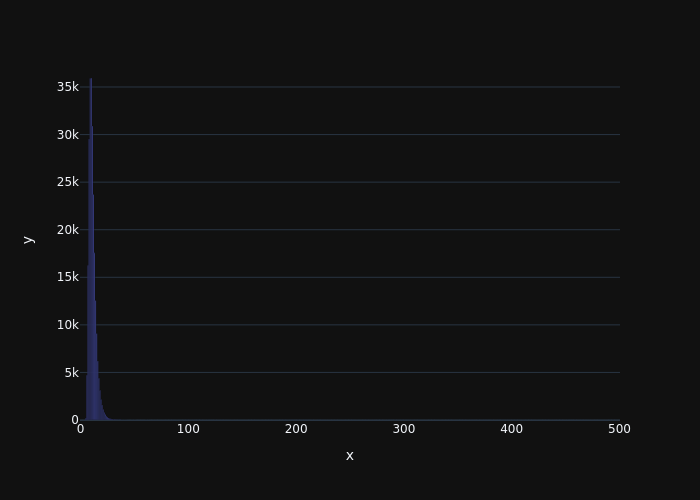

In [19]:
all_tokens = en_tokens_len.tolist()+es_tokens_len.tolist()
counts,bins = np.histogram(all_tokens,bins=np.linspace(0,500,501))
fig = px.bar(y=[0]+counts.tolist(),x=bins.tolist())
fig.show("png")

In [20]:
MAX_TOKENS = 128
def prepare_ds(en,es):
    en = up_stream_processing(en,"en")
    es = up_stream_processing(es,"es")
    en = en[:,:MAX_TOKENS]
    es = es[:,:MAX_TOKENS]
    return (en.to_tensor(),es[:,:-1].to_tensor()),es[:,1:].to_tensor()

In [21]:
BATCH_SIZE = 64
AUTO = tf.data.AUTOTUNE
en_array = np.array(en_text)
es_array = np.array(es_text)
all_indices = np.random.uniform(size=len(en_text))
train_mask = all_indices <= 0.8
valid_mask = (all_indices > 0.8) & (all_indices <= 0.95)
test_mask = all_indices > 0.95
train_ds = (
    tf.data.Dataset
    .from_tensor_slices((en_array[train_mask],es_array[train_mask]))
    .shuffle(len(en_text))
    .batch(BATCH_SIZE)
    .map(prepare_ds)
    .prefetch(AUTO)
)
valid_ds = (
    tf.data.Dataset
    .from_tensor_slices((en_array[valid_mask],es_array[valid_mask]))
    .shuffle(len(en_text))
    .batch(BATCH_SIZE)
    .map(prepare_ds)
    .prefetch(AUTO)
)
test_ds = (
    tf.data.Dataset
    .from_tensor_slices((en_array[test_mask],es_array[test_mask]))
    .shuffle(len(en_text))
    .batch(BATCH_SIZE)
    .map(prepare_ds)
    .prefetch(AUTO)
)

In [22]:
for (en_in,es_in),tar_in in train_ds.take(1):
    print(en_in.shape,es_in.shape,tar_in.shape)
    print(es_in[0,:10])
    print(tar_in[0,:10])

(64, 17) (64, 19) (64, 19)
tf.Tensor([  2  34  77  67 249   7   0   0   0   0], shape=(10,), dtype=int64)
tf.Tensor([ 34  77  67 249   7   3   0   0   0   0], shape=(10,), dtype=int64)


# Transformers

<table>
<tr>
  <th colspan=1>The original Transformer diagram</th>
  <th colspan=1>A representation of a 4-layer Transformer</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png"/>
  </td>
  <td>
   <img width=307 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-4layer-compact.png"/>
  </td>
</tr>
</table>

Each of the components in these two diagrams will be explained as you progress through the tutorial.

## Embedding and Positional Encoding layer

The inputs to both the encoder and decoder use the same embedding and positional encoding logic.

<table>
<tr>
  <th colspan=1>The embedding and positional encoding layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/PositionalEmbedding.png"/>
  </td>
</tr>
</table>

- Given a sequence of tokens, both the input tokens (ENGLISH) and target tokens (SPANISH) have to be converted to vectors using a ```keras.layers.Embedding``` layer
- The attention layers used throughout the model see their input as a set of vectors, with no order. Since the model doesn't contain any recurrent layers or convolutional layers. It needs some way to idientify word order, otherwise is would see the input sequence as a bag of words for instance, 
  - ```how are you```
  - ```you are how```
  - ```are you how```
  - ```you how are```

- A Transformer adds "Positional Encoding" to the embedding vectors. It uses a set of sines and consines at frequencies (across the sequence). By definition nearby elements will have similar position encodings

- The original paper uses the following formula for calculating the positional encoding:
$$ PE_{(pos,2i)} = sin\Biggl( \frac{pos}{10000^{\frac{2i}{d_{model}}}}\Biggr)$$

- The Original paper uses interleaving sines and cosines but we are going to concatenate it


In [23]:
en_embedding = keras.layers.Embedding(len(en_vocab),512,mask_zero=True)
es_embedding = keras.layers.Embedding(len(spa_vocab),512,mask_zero=True)

In [44]:
depth = 512//2
positions = np.arange(2048)[:,np.newaxis]
print(f"positions[:10]: \n{positions[:10]}") # (seq,1)
print("with shape",positions.shape)
print()
depths = np.arange(depth)[np.newaxis,:]/depth
print(f"depths[:,:10]: \n{depths[0,:10]}") # (1,depth) depths are in half-fractions from 0 leading upto 255/256
print(f"with shape",depths.shape)
print()
angle_rates = 1/(10000**depths)
print(f"angle_rates[:,:10]:\n{angle_rates[0,:10]}") # (1,depth) angles rates are inverse exponential to the depths from 1 to 1/10000**(0.9..) ~ 1e-4
print(f"with shape",angle_rates.shape)
print()
angle_rads = positions*angle_rates
print(f"angle_radians[:,:10]: \n{angle_rads[:2,:10]}")
print("with shape",angle_rads.shape)
print()
pos_encoding_concatenating = np.concatenate([np.sin(angle_rads),np.cos(angle_rads)],axis=-1)
print(f"pos_encoding[:,:10]: \n{pos_encoding_concatenating[:2,:10]}")
print("with shape",pos_encoding_concatenating.shape)
print()
pos_encoding_concatenating_casted = tf.cast(pos_encoding_concatenating,tf.float32)

positions[:10]: 
[[0]
 [1]
 [2]
 [3]
 [4]
 [5]
 [6]
 [7]
 [8]
 [9]]
with shape (2048, 1)

depths[:,:10]: 
[0.         0.00390625 0.0078125  0.01171875 0.015625   0.01953125
 0.0234375  0.02734375 0.03125    0.03515625]
with shape (1, 256)

angle_rates[:,:10]:
[1.         0.96466162 0.93057204 0.89768713 0.86596432 0.83536255
 0.80584219 0.77736503 0.74989421 0.72339416]
with shape (1, 256)

angle_radians[:,:10]: 
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [1.         0.96466162 0.93057204 0.89768713 0.86596432 0.83536255
  0.80584219 0.77736503 0.74989421 0.72339416]]
with shape (2048, 256)

pos_encoding[:,:10]: 
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.84147098 0.82185619 0.8019618  0.78188711 0.76172041 0.7415398
  0.72141412 0.70140374 0.68156135 0.66193262]]
with shape (2048, 512)



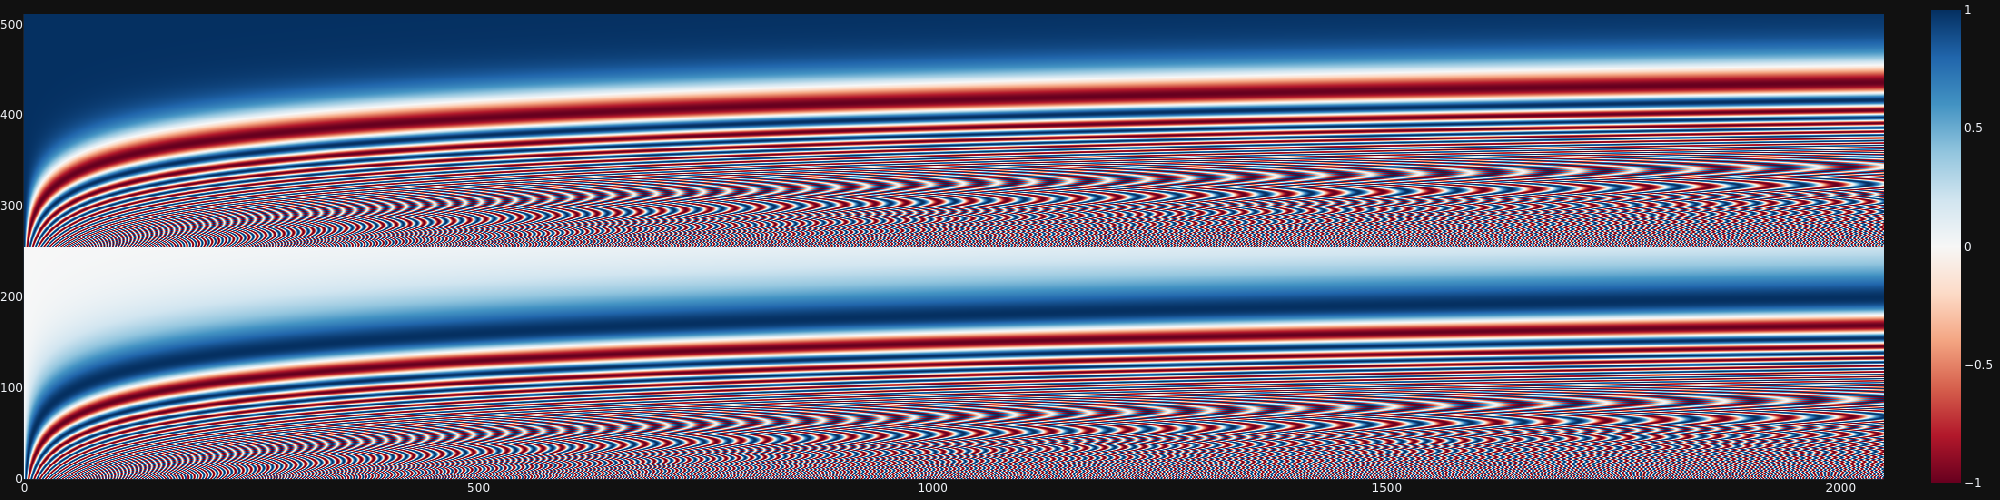

In [104]:
fig = px.imshow(img=pos_encoding_concatenating_casted.numpy().T,color_continuous_scale=px.colors.sequential.RdBu,origin="lower")
fig.update_layout(margin=dict(l=20,r=0,t=0,b=0))
fig.show("png",width=2000)